In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [ ]:
df = pd.read_csv('/content/AirPassengers (1).csv')

In [ ]:
df.head(10)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


In [ ]:
#Load
df_raw = pd.read_csv('/content/AirPassengers (1).csv')
print("Columns:", df_raw.columns.tolist())
date_col = 'Month'  # for this file
df = pd.read_csv('/content/AirPassengers (1).csv', parse_dates=[date_col], index_col=date_col)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

Columns: ['Month', '#Passengers']


In [ ]:
# Choose series
series_col = '#Passengers'
ts = df[series_col].sort_index().astype(float)

In [ ]:
# Basic info
print("Range:", ts.index.min(), "to", ts.index.max(), "N=", len(ts))
print(ts.head())

Range: 1949-01-01 00:00:00 to 1960-12-01 00:00:00 N= 144
Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
Name: #Passengers, dtype: float64


In [ ]:
#Summary stats
print(ts.describe())

count    144.000000
mean     280.298611
std      119.966317
min      104.000000
25%      180.000000
50%      265.500000
75%      360.500000
max      622.000000
Name: #Passengers, dtype: float64


In [ ]:
# Missing / duplicates
print("Missing:", ts.isna().sum(), "Duplicate index entries:", ts.index.duplicated().sum())

Missing: 0 Duplicate index entries: 0


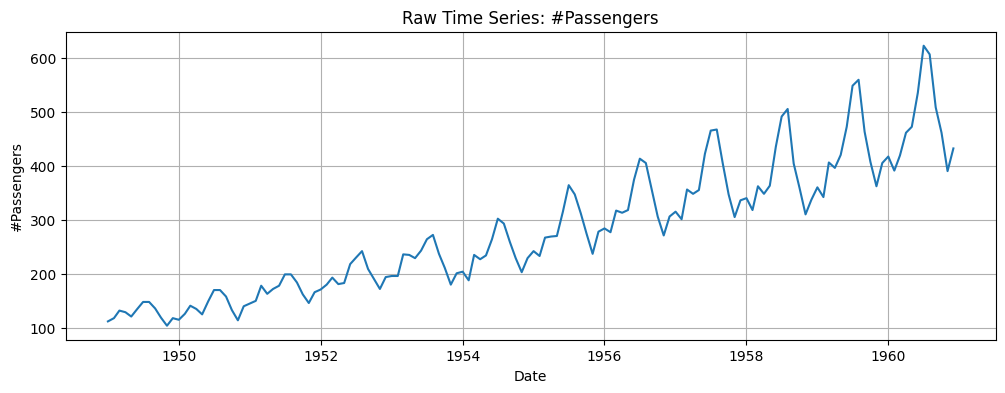

In [ ]:
# Raw series plot
plt.figure(figsize=(12,4))
plt.plot(ts.index, ts.values)
plt.title('Raw Time Series: ' + series_col)
plt.xlabel('Date'); plt.ylabel(series_col); plt.grid(True)
plt.show()

In [ ]:
# Infer frequency & set period
freq = pd.infer_freq(ts.index)
print("Inferred freq:", freq)
period = 12 if len(ts) > 24 else None

Inferred freq: MS


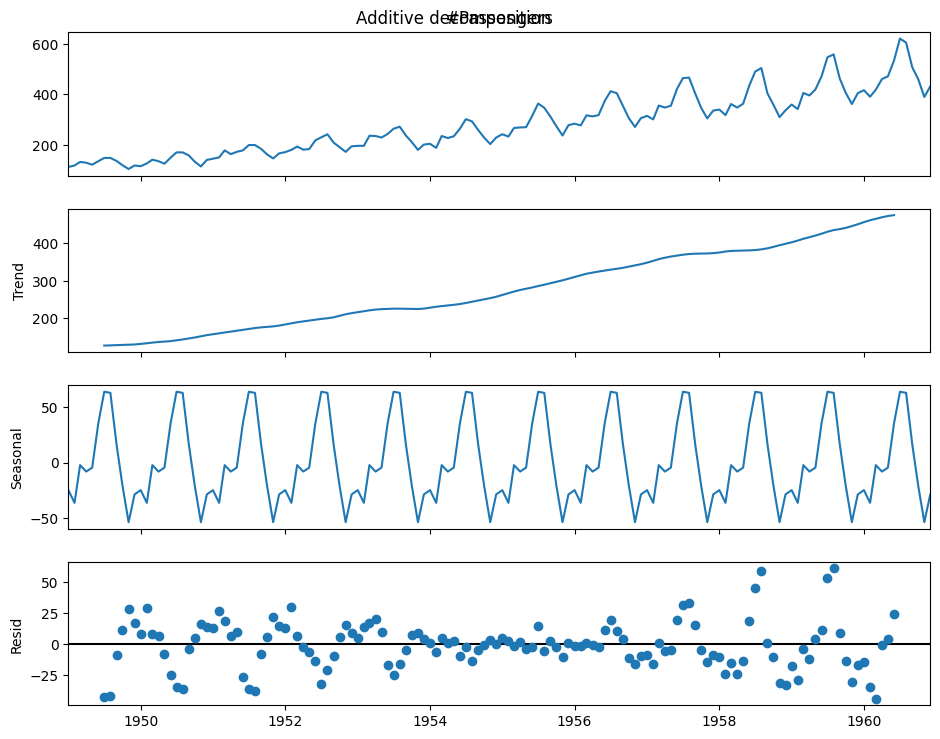

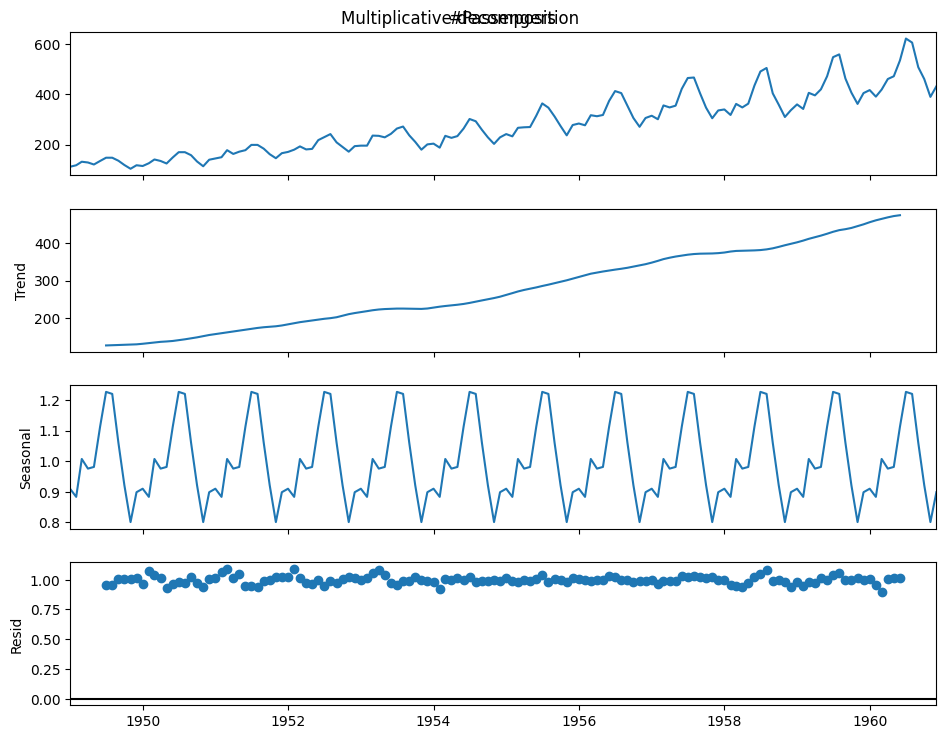

In [ ]:
# Decomposition additive & multiplicative
if period:
    sd_add = seasonal_decompose(ts, model='additive', period=period)
    sd_mul = seasonal_decompose(ts, model='multiplicative', period=period)
    sd_add.plot().set_size_inches(10,8); plt.suptitle('Additive decomposition', y=0.95); plt.show()
    sd_mul.plot().set_size_inches(10,8); plt.suptitle('Multiplicative decomposition', y=0.95); plt.show()

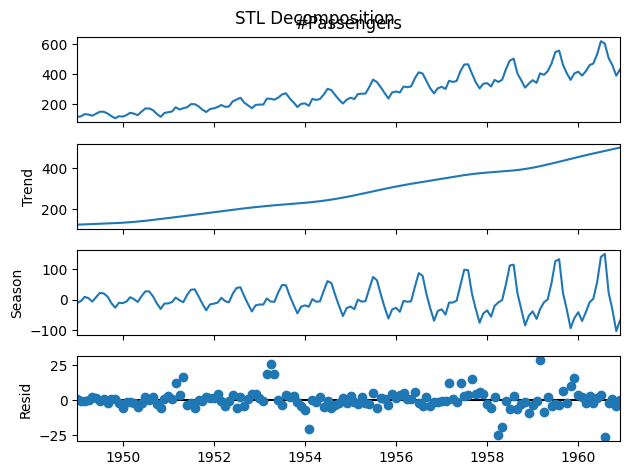

In [ ]:
# STL decomposition (robust)
if period is None and len(ts) >= 24:
    period = 12
if period:
    stl = STL(ts, period=period, robust=True).fit()
    stl.plot(); plt.suptitle('STL Decomposition'); plt.show()

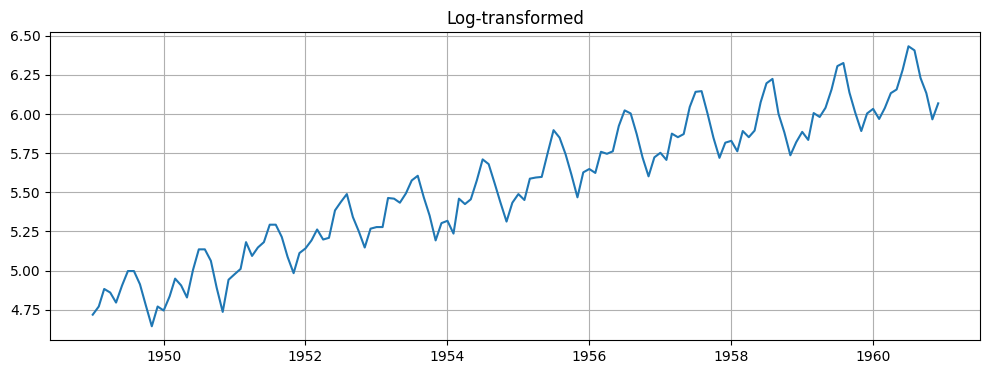

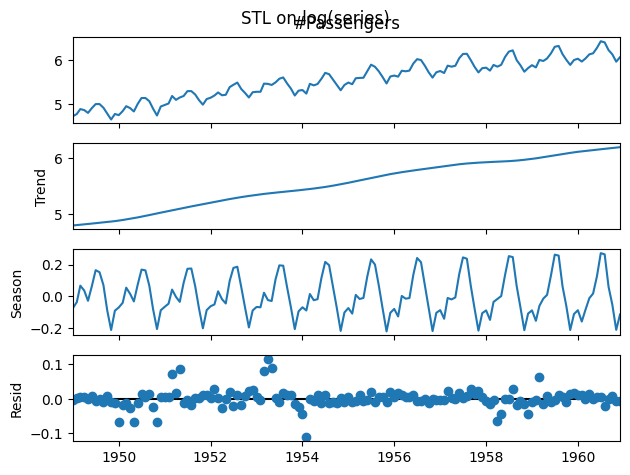

In [ ]:
 # Log transform
ts_log = np.log(ts)
plt.figure(figsize=(12,4)); plt.plot(ts_log); plt.title('Log-transformed'); plt.grid(True); plt.show()
if period:
    STL(ts_log, period=period, robust=True).fit().plot(); plt.suptitle('STL on log(series)'); plt.show()

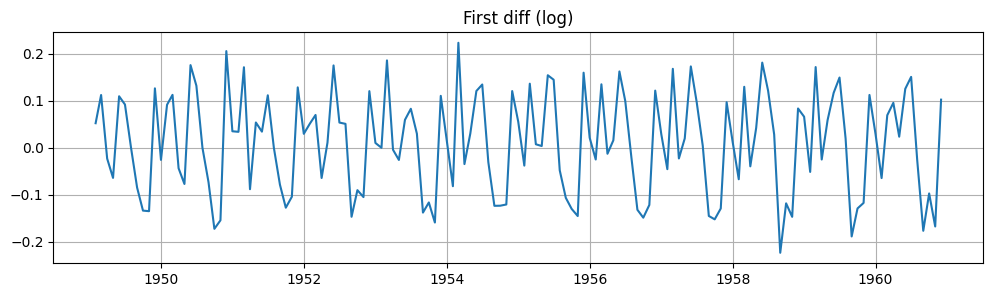

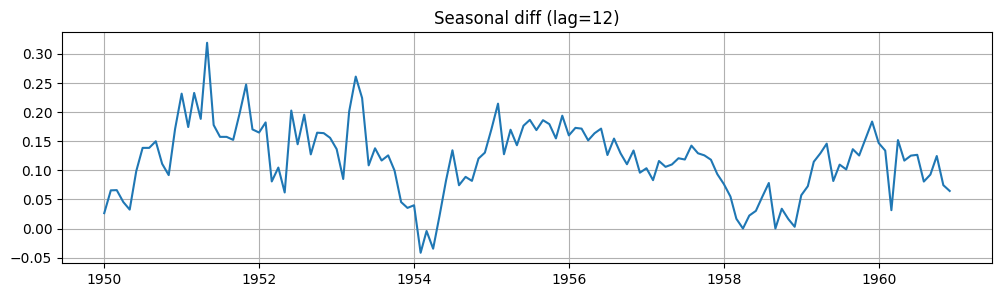

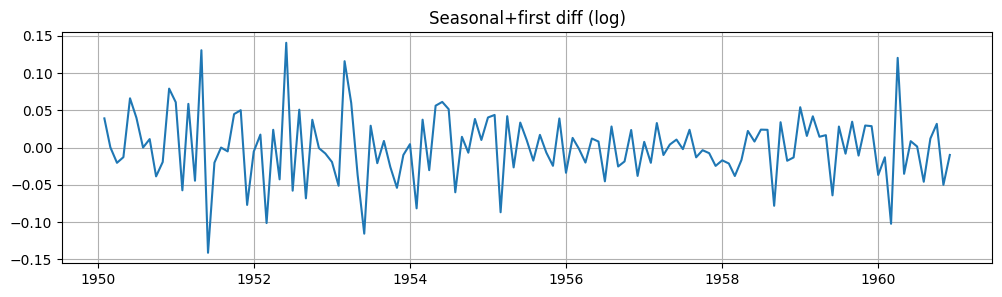

In [ ]:
# Differencing
first_diff = ts_log.diff().dropna()
seasonal_diff = ts_log.diff(period).dropna() if period else None
seasonal_first = (ts_log.diff(period).diff()).dropna() if period else None
plt.figure(figsize=(12,3)); plt.plot(first_diff); plt.title('First diff (log)'); plt.grid(True); plt.show()
if seasonal_diff is not None:
    plt.figure(figsize=(12,3)); plt.plot(seasonal_diff); plt.title(f'Seasonal diff (lag={period})'); plt.grid(True); plt.show()
if seasonal_first is not None:
    plt.figure(figsize=(12,3)); plt.plot(seasonal_first); plt.title('Seasonal+first diff (log)'); plt.grid(True); plt.show()


In [ ]:
# ADF tests
def run_adf(series, name):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f"ADF on {name}: stat={result[0]:.6f}, p={result[1]:.6f}")
run_adf(ts, 'Raw')
run_adf(ts_log, 'Log')
run_adf(first_diff, 'First diff (log)')
if seasonal_first is not None:
    run_adf(seasonal_first, 'Seasonal+First diff (log)')

ADF on Raw: stat=0.815369, p=0.991880
ADF on Log: stat=-1.717017, p=0.422367
ADF on First diff (log): stat=-2.717131, p=0.071121
ADF on Seasonal+First diff (log): stat=-4.443325, p=0.000249


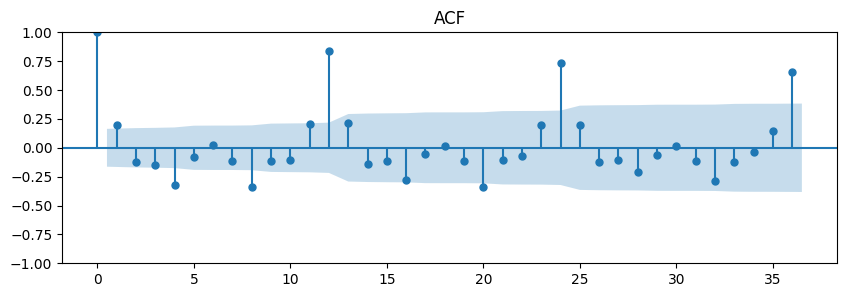

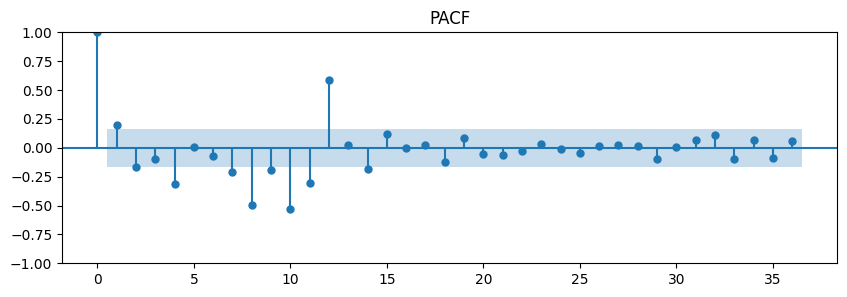

In [ ]:
# ACF / PACF (on first_diff)
plt.figure(figsize=(10,3)); plot_acf(first_diff, lags=36, ax=plt.gca()); plt.title('ACF'); plt.show()
plt.figure(figsize=(10,3)); plot_pacf(first_diff, lags=36, ax=plt.gca(), method='ywm'); plt.title('PACF'); plt.show()

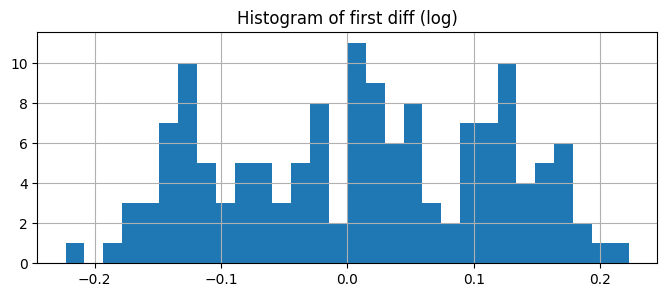

count    143.000000
mean       0.009440
std        0.106556
min       -0.223144
25%       -0.080024
50%        0.014815
75%        0.105882
max        0.223144
Name: #Passengers, dtype: float64


In [ ]:
# Histogram of first_diff
plt.figure(figsize=(8,3)); plt.hist(first_diff, bins=30); plt.title('Histogram of first diff (log)'); plt.grid(True); plt.show()
print(first_diff.describe())

In [ ]:
# Outliers
thr = 3*first_diff.std()
outliers = first_diff[np.abs(first_diff) > thr]
print("Outliers count:", len(outliers))
print(outliers.head())

Outliers count: 0
Series([], Name: #Passengers, dtype: float64)


In [ ]:
#Feature engineering (month/year, rolling, lags)
df_features = pd.DataFrame(ts).rename(columns={series_col: 'value'})
df_features['year'] = df_features.index.year
df_features['month'] = df_features.index.month
df_features['rolling_12'] = df_features['value'].rolling(12).mean()
df_features['lag_1'] = df_features['value'].shift(1)
df_features['pct_change_1'] = df_features['value'].pct_change()
df_features.to_csv('/content/ts_eda_features.csv')
print("Saved features CSV to /content/ts_eda_features.csv")
print(df_features.head())

Saved features CSV to /content/ts_eda_features.csv
            value  year  month  rolling_12  lag_1  pct_change_1
Month                                                          
1949-01-01  112.0  1949      1         NaN    NaN           NaN
1949-02-01  118.0  1949      2         NaN  112.0      0.053571
1949-03-01  132.0  1949      3         NaN  118.0      0.118644
1949-04-01  129.0  1949      4         NaN  132.0     -0.022727
1949-05-01  121.0  1949      5         NaN  129.0     -0.062016


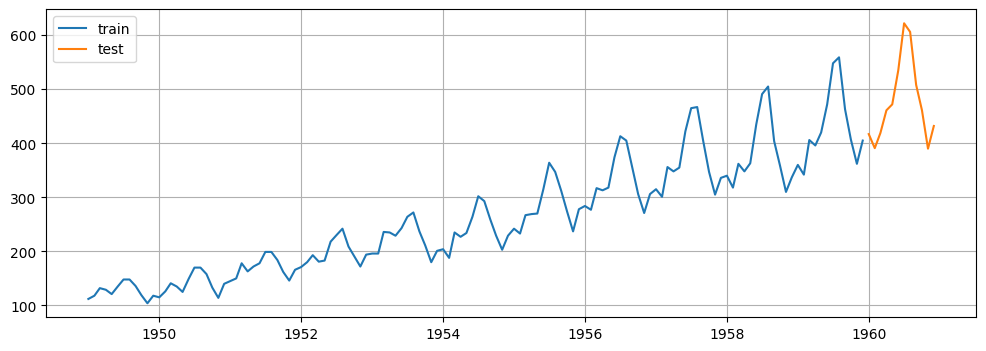

In [ ]:
# Train/test example
n_test = min(12, max(1, len(ts)//10))
train = ts.iloc[:-n_test]; test = ts.iloc[-n_test:]
plt.figure(figsize=(12,4)); plt.plot(train, label='train'); plt.plot(test, label='test'); plt.legend(); plt.grid(True); plt.show()

This code performs a full exploratory analysis of the AirPassengers dataset.
Key steps include:

Data loading & cleaning: Convert dates, check missing values, and inspect basic statistics.

Visualization: Plot the raw series, which shows a clear trend, monthly seasonality, and increasing variance.

Decomposition: Use additive, multiplicative, and STL methods to separate the data into trend, seasonality, and residuals.

Transformations: Apply log transform and differencing (first + seasonal) to stabilize the series.

Stationarity testing: ADF test shows the data becomes stationary only after seasonal + first differencing.

ACF/PACF analysis: Identifies strong yearly seasonality and helps determine ARIMA/SARIMA parameters.

Outliers & distribution: Histogram and ±3σ check used to detect extreme changes.

Feature engineering: Create rolling mean, lag features, and percent change; save as CSV.

Train-test split: Last 12 months used for testing; remainder for training.

Overall, the dataset shows strong trend and seasonality and is prepared for time-series forecasting models.